In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import nltk
from arabica import arabica_freq
from unidecode import unidecode
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import nltk
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
import re
import nlp
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

2023-09-19 17:57:57.943002: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 17:57:58.168126: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 17:57:58.169125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 17:57:59.532894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('sentimento - base2.csv')

In [3]:
df.head()

,id_issue,mes_chat,SENTIMENTO,TIPO_MSG,hierarquia_4,ds_cluster_sociodemographic,ds_message,flag_negativo_indecx
0,15388962,2023-04-01,neutro,duvida,Vencimento fatura,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...","['Que dia minha fatura fecha?','Ainda tenho dú...",0
1,17497395,2023-07-01,neutro,duvida,Dúvidas sobre pagamento de fatura,"11 - Homem, Solteiro, Até 24 anos, cidade Pequ...","['Quero pagar os 100 reais que eu tirei','Mais...",0
2,15213047,2023-04-01,neutro,solicitacao,Não reconhecimento de compra no crédito,"17 - Mulher, 25 a 40 anos, Sudeste e Sul","['Apareceu uma compra que eu não fiz','Dúvida ...",0
3,17117301,2023-06-01,neutro,problema,Parcelamento de fatura,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",['No meu limite está escrito que está utilizad...,0
4,17345996,2023-07-01,negativo,problema,Dúvidas PIX,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...","['Pix','E merda o will nunca teve essas coisas...",0


In [27]:
#############################################################
####### INCLUINDO PALAVRAS CHAVE ###########
##############################################################

def clean_text(x):
    x = unidecode(x)
    x = x.strip()
    x = x.lower()
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'Falar de outra coisa', '', x)
    x = re.sub(r'Voltar pro começo', '', x)
    x = re.sub(r'É outro assunto', '', x)
    x = re.sub(r'Voltar', '', x)
    x = re.sub(r'Mais opções', '', x)
    
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    #x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    #x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x


In [5]:
len(df)

14906

In [28]:
# não vou remover emojis
df['ds_message_tratada'] = df['ds_message'].apply(clean_text)

In [29]:
exemplo_base = df[df['SENTIMENTO'].notnull()]
len(exemplo_base)

512

In [30]:
stopwords_will= ['da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce',
                 'pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro',
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um','como', 'meu', 'com', 'outro','outra','das','dos','foi', 'fiz','pelo','tem','mas',
            'este', 'esse','ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro', 'isso']

In [31]:
exemplo_base['SENTIMENTO_label'] = np.where(exemplo_base['SENTIMENTO'] == "negativo", 0, 
                                            np.where(exemplo_base['SENTIMENTO'] == "neutro", 1, 2 ))

/tmp/ipykernel_448391/2720231541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
from sklearn.neural_network import MLPClassifier

vetorizador = TfidfVectorizer()
X = vetorizador.fit_transform(exemplo_base['ds_message_tratada'])
y = exemplo_base.SENTIMENTO_label

x_train, x_test, y_train, y_test = train_test_split(X
                                                    , exemplo_base.SENTIMENTO_label
                                                    , random_state=42, test_size=0.20)

clf = MLPClassifier(solver='lbfgs', random_state=1) #alpha=0.0001

clf = clf.fit(x_train, y_train)
y_predicted = clf.predict(x_test)
pd.crosstab(y_predicted, y_test)

SENTIMENTO_label,0,1,2
row_0,,,
0,35,7,5
1,9,29,7
2,2,1,8


In [35]:
exemplo_base.head(3)

,id_issue,mes_chat,SENTIMENTO,TIPO_MSG,hierarquia_4,ds_cluster_sociodemographic,ds_message,flag_negativo_indecx,ds_message_tratada,SENTIMENTO_label
0,15388962,2023-04-01,neutro,duvida,Vencimento fatura,"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...","['Que dia minha fatura fecha?','Ainda tenho dú...",0,"['que dia minha fatura fecha?','ainda tenho du...",1
1,17497395,2023-07-01,neutro,duvida,Dúvidas sobre pagamento de fatura,"11 - Homem, Solteiro, Até 24 anos, cidade Pequ...","['Quero pagar os 100 reais que eu tirei','Mais...",0,"['quero pagar os 100 reais que eu tirei','mais...",1
2,15213047,2023-04-01,neutro,solicitacao,Não reconhecimento de compra no crédito,"17 - Mulher, 25 a 40 anos, Sudeste e Sul","['Apareceu uma compra que eu não fiz','Dúvida ...",0,"['apareceu uma compra que eu nao fiz','duvida ...",1


In [33]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='f1_macro')
print("%0.2f F1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.66 F1 with a standard deviation of 0.04


In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75        46
           1       0.64      0.78      0.71        37
           2       0.73      0.40      0.52        20

    accuracy                           0.70       103
   macro avg       0.71      0.65      0.66       103
weighted avg       0.71      0.70      0.69       103



In [36]:
exemplo_base['predito'] = clf.predict(X)

/tmp/ipykernel_448391/1539981503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


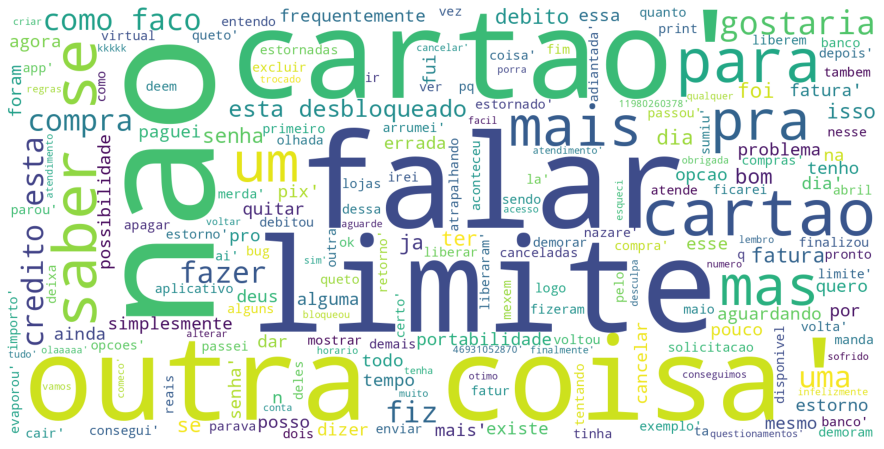

In [37]:
base_cloud = exemplo_base[(exemplo_base['SENTIMENTO_label'] == 0) & (exemplo_base['predito'] == 1)]['ds_message_tratada']

all_other = " ".join(s for s in base_cloud)

stopwords = set(STOPWORDS)
pstop = ["da", "meu", "em", "você", "de", "ao", "os", "que", "e", 'eu', 'o', 'estou', '*','pag' , 'do', 'e', 'novo', 'a', 'mp', 'pg', 'zp']
stopwords.update(pstop)

wordcloud = WordCloud(stopwords=stopwords,
                      max_font_size = 300,
                      background_color='white', width=1600,                            
                      height=800).generate(all_other)

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

In [38]:
print(base_cloud.unique())

["['quanto tempo pro estorno cair','estorno na fatura','problema com compra','fatura do cartao','esse tempo ja passou','to tentando manda o print so q n da certo','mostrar o exemplo']"
 "['pix','todo dia da problema nesse aplicativo deus e mais','falar de outra coisa','nao da pra fazer pix']"
 "['falar de outra coisa','72$ 16072023 mp nazare','passei o cartao e nao finalizou a compra mas debitou do meu limite e ainda n foi estornado','?????']"
 "['tenho que ir no meu banco primeiro e cancelar por la','nao consegui','eu fiz uma portabilidade errada e quero excluir,como faco?','eu fiz uma solicitacao de portabilidade errada queto apagar como faco??','falar de outra coisa','se for demorar deixa queto','mais opcoes','ja arrumei','pq atende virtual e uma merda']"
 '[\'nao entendo o que aconteceu com o limite do meu cartao\',\'tinha $600 e alguns reais para fazer compras\',\'fui fazer as compras e simplesmente o limite sumiu\',\'mas dessa vez ta me atrapalhando!!!\',\'frequentemente mexem no

### Tratamento está tirando a interrogação?

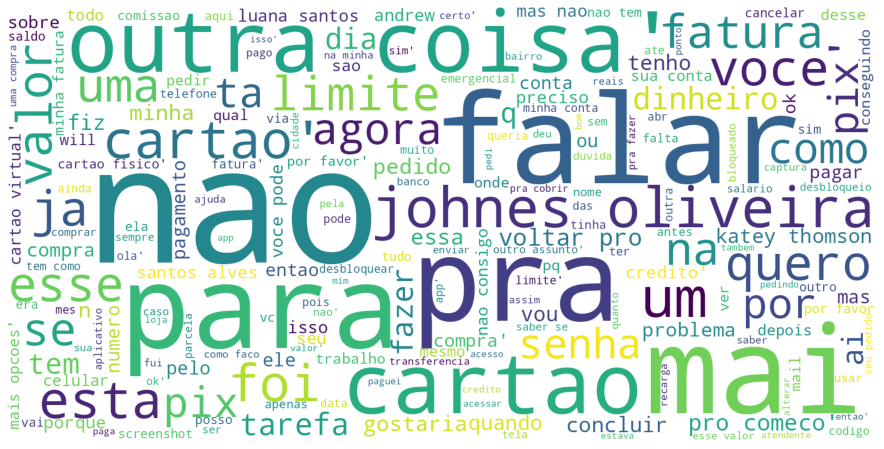

In [39]:
base_cloud = exemplo_base[(exemplo_base['SENTIMENTO_label'] == 1) & (exemplo_base['predito'] == 1)]['ds_message_tratada']

all_other = " ".join(s for s in base_cloud)

stopwords = set(STOPWORDS)
pstop = ["da", "meu", "em", "você", "de", "ao", "os", "que", "e", 'eu', 'o', 'estou', '*','pag' , 'do', 'e', 'novo', 'a', 'mp', 'pg', 'zp']
stopwords.update(pstop)

wordcloud = WordCloud(stopwords=stopwords,
                      max_font_size = 300,
                      background_color='white', width=1600,                            
                      height=800).generate(all_other)

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

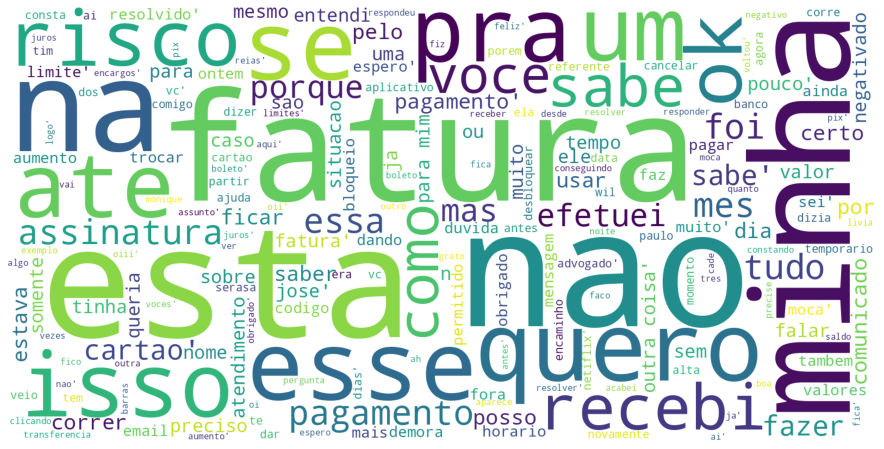

In [40]:
base_cloud = exemplo_base[(exemplo_base['SENTIMENTO_label'] == 2) & (exemplo_base['predito'] == 0)]['ds_message_tratada']

all_other = " ".join(s for s in base_cloud)

stopwords = set(STOPWORDS)
pstop = ["da", "meu", "em", "você", "de", "ao", "os", "que", "e", 'eu', 'o', 'estou', '*','pag' , 'do', 'e', 'novo', 'a', 'mp', 'pg', 'zp']
stopwords.update(pstop)

wordcloud = WordCloud(stopwords=stopwords,
                      max_font_size = 300,
                      background_color='white', width=1600,                            
                      height=800).generate(all_other)

fig, ax = plt.subplots(figsize=(16,8))
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)

In [41]:
print(base_cloud.unique())

["['preciso sabe como vai fica','oiii','voce?','fatura do cartao','fico feliz','faz tempo que espero um aumento','atendimento demora muito','nao esta dando pra fazer transferencia ','pix','livia eu sei','acabei de ver aqui','voce ainda esta ai','encargos','e outro assunto','quero sabe','responder mensagem de antes','nao obrigado','oi,monique?','falar de outra coisa','pra resolver','mais esta constando na fatura tres vezes os valores e juros','cade voces','isso eu sei','fiz um pagamento de boleto ,valor voltou','moca','quero sabe sobre esse valor da fatura 700 e pouco','moca?','sobre limites','oii','boa noite nao to conseguindo fazer pagamento','e pix tudo que eu faco fica juros e saldo negativo na fatura ,quero resolver isso logo','voce nao respondeu minha pergunta moca','quero sabe sobre aumento de limite','foi resolvido','desde de ontem que espero','que faz tempo que espero','valor e 195 reias','quero sabe quanto tempo demora pra me receber aumento de limite','e grato que ja foi reso

## Próximos:
#### - Retirar "Falar de outra coisa" e outras frases padrão e rodar novamente
#### - Incluir Regra de palavras chave